# STAT5243 Project 4: Causal Inference

***Group 2:***

    Wendy Doan
    Yibai Liu
    Yiwen Fang
    Shuqi Yu
    Zhihang Xia

## Introduction

In this project, we studied **Causal Inference** on two datasets, one high-dimensional and another low-dimensional. 

Specifically, we estimated the **Average Treatment Effects (ATE)** by calculating the **Propensity Scores (PS)** using the **Boosting Stumps** algorithm. 

The ATEs are then calculated using three models and compared with the true values to estimate accuracy. For each algorithm and method,  The performance and computational efficiency were evaluated for each dataset to select the best combination. 

Propensity Scores: (Boosting Stumps)
1. GBM 
2. XGboost

ATE Estimation Methods:
1. Stratification
2. Regression Adjustment
3. Stratification + Regression Adjustment 

To aid with propensity score prediction, we also attempted to alleviate the slight imbalance in the data through well known methods such as oversampling and SMOTE.

## Propensity Score Estimation

We define the propensity score as:

$$e(x) = Pr(T =1|X=x)$$

The propensity score is given in term of probability 

$$0<e(x)<1$$


##  Step 0: Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set a random seed for reproduction.
RANDOM_STATE = np.random.seed(42)

# train-test split for propensity score
from sklearn.model_selection import train_test_split

# baseline propensity score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

# grid search
from sklearn.model_selection import GridSearchCV

# propensity score from tree models
import xgboost as xgb
from xgboost import XGBClassifier

# GBM
from sklearn.ensemble import GradientBoostingClassifier

# Stratification and Regression Adjustment
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression

# Imbalance techniques
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
#from imblearn.under_sampling import RandomUnderSampler
#from imblearn.under_sampling import NearMiss

## Step 1: Import and explore data

To increase the usability of the notebook, we use generic variable names instead of associating with the datasets used in for the project. To use the notebook with other datasets, simply import with variable name `dataset`

We have two dataset, `High Dimensional Dataset` and `Low Dimensional Dataset`

In [2]:
# Set up your directory for the datasets
directory = "../"

In [3]:
highDim_dataset = pd.read_csv(directory + 'data/highDim_dataset.csv')
lowDim_dataset = pd.read_csv(directory + 'data/lowDim_dataset.csv')

The goal of this project is estimating the ATE of two dataset: high and low dimensional. 

In [4]:
high_true_ATE = -54.8558
low_true_ATE = 2.0901

In [5]:
##############################################################################
##############################################################################
# Choose a development option between highDim_dataset and lowDim_dataset

dataset = lowDim_dataset.copy()
dataset_name = "Low-Dimensional Dataset"
true_ATE = low_true_ATE

#dataset = highDim_dataset.copy()
#dataset_name = "High-Dimensional Dataset"
#true_ATE = high_true_ATE

In [6]:
dataset.head()

,Y,A,V1,V2,V3,V4,V5,V6,V7,V8,...,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22
0,30.486999,0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,...,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,9.09,1.149622
1,18.208417,0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,1.40,...,0.7,0.00,1.40,0.0,1.40,0.0,0.00,0.00,0.00,2.887702
2,13.485040,0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,...,0.0,0.00,3.57,0.0,0.00,0.0,0.00,0.00,0.00,0.000000
3,25.699678,1,2.38,0.00,0.00,0.0,0.0,0.00,0.0,0.00,...,0.0,0.00,2.38,0.0,2.38,0.0,0.00,0.00,0.00,0.405465
4,23.752968,0,0.15,0.15,0.05,0.1,0.0,0.42,0.1,0.95,...,0.0,0.36,3.16,0.0,1.58,0.0,0.52,0.31,0.00,1.574639


The high-dimensional dataset has 2000 observations of 187 dimensions, while the low-dimensional dataset has 500 observations of 24 dimensions.

It is convenient to extract only the X portion, which is columns other than Y (treatment result) and A (binary treatment/control group)

In [7]:
data_X = dataset.drop(['Y', 'A'], axis=1).copy()

In [8]:
data_X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22
0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,...,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,9.09,1.149622
1,0.00,0.00,0.00,0.0,0.0,0.00,0.0,1.40,0.00,0.00,...,0.7,0.00,1.40,0.0,1.40,0.0,0.00,0.00,0.00,2.887702
2,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,...,0.0,0.00,3.57,0.0,0.00,0.0,0.00,0.00,0.00,0.000000
3,2.38,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,...,0.0,0.00,2.38,0.0,2.38,0.0,0.00,0.00,0.00,0.405465
4,0.15,0.15,0.05,0.1,0.0,0.42,0.1,0.95,0.42,0.05,...,0.0,0.36,3.16,0.0,1.58,0.0,0.52,0.31,0.00,1.574639


In [9]:
def plotComposition(dataset, reset_index=False):
    plt.plot(dataset[dataset.A == 1].Y.reset_index(drop=True) 
             if reset_index 
             else dataset[dataset.A == 1].Y, 'o', label='Treatment')
    plt.plot(dataset[dataset.A == 0].Y.reset_index(drop=True) 
             if reset_index 
             else dataset[dataset.A == 0].Y, 'ro', label='Control')
    plt.title(dataset_name + " Distribution")
    plt.ylabel("Y")
    plt.legend()
    plt.show()

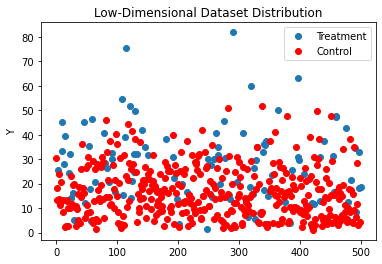

In [10]:
plotComposition(dataset)

## Step 2: Naive estimate of ATE

Check the origianl ATE for both high and low dimension data without any steps and algorithms

In [11]:
def naive_ATE(dataset):
    return np.average(dataset[dataset.A == 1].Y) - np.average(dataset[dataset.A == 0].Y)

In [12]:
print("Naive ATE for high-dimensional data:", naive_ATE(highDim_dataset))
print("Naive ATE for low-dimensional data:", naive_ATE(lowDim_dataset))

Naive ATE for high-dimensional data: -75.17133436876799
Naive ATE for low-dimensional data: 10.602068661915688


## Step 3: Data preprocessing


### Are the data sets balanced?

In [13]:
def checkComposition(dataset):
    print("The dataset contains:\n",len(dataset[dataset.A == 1]), "cases in Treatment group\n", 
          len(dataset[dataset.A == 0]), "cases in Control group.")
    print("Treatment/Control ratio: {}/100".format(round(len(dataset[dataset.A == 1])/len(dataset[dataset.A == 0])*100)))

In [14]:
print("High-dimensional")
checkComposition(highDim_dataset)
print('-'*20)
print("Low-dimensional")
checkComposition(lowDim_dataset)

High-dimensional
The dataset contains:
 643 cases in Treatment group
 1357 cases in Control group.
Treatment/Control ratio: 47/100
--------------------
Low-dimensional
The dataset contains:
 106 cases in Treatment group
 394 cases in Control group.
Treatment/Control ratio: 27/100


In this case, the high-dimensional data is slightly imbalanced, but acceptable. However, the low-dimensional data displays severer imbalance between groups. In any cases, one can use oversampling or smote to balance the data, which however may not be beneficial for some ATE estimation algorithms. 

### Oversampling to deal with the imbalanced data

Resampling data is one of the most commonly preferred approaches to deal with an imbalanced dataset. We used oversampling the minority instead of undersampling the majority since undersampling removes instances from data that may be carrying important information.


1. **Random Oversampling**: 

To randomly replicate the small sample to match the size of the larger sample.

2. **SMOTE**: Synthetic Minority Oversampling Technique

SMOTE generates synthetic samples from the minority class. This algorithm helps to overcome the overfitting problem posed by random oversampling. It focuses on the feature space to generate new instances with the help of interpolation between the positive instances that lie together.



In [15]:
def Oversample(dataset):
    ovs = RandomOverSampler(random_state = RANDOM_STATE)
    x, y = ovs.fit_resample(dataset.loc[:, dataset.columns != 'A'], dataset.A)
    x.insert(1, 'A', y)
    return x

The dataset contains:
 394 cases in Treatment group
 394 cases in Control group.
Treatment/Control ratio: 100/100


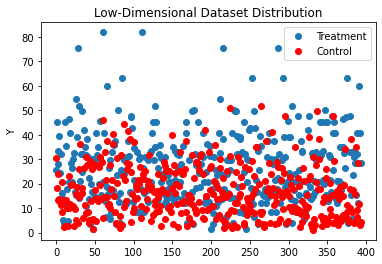

In [16]:
dataset_oversampled = Oversample(dataset)

checkComposition(dataset_oversampled)
plotComposition(dataset_oversampled, reset_index=True)

In [17]:
def SMOTE(dataset):
    smk = SMOTETomek()
    x, y = smk.fit_resample(dataset.loc[:, dataset.columns != 'A'], dataset.A)
    x.insert(1, 'A', y)
    return x

The dataset contains:
 384 cases in Treatment group
 384 cases in Control group.
Treatment/Control ratio: 100/100


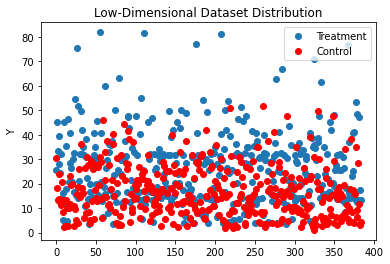

In [18]:
dataset_smote = SMOTE(dataset)

checkComposition(dataset_smote)
plotComposition(dataset_smote, reset_index=True)

In summary, there are three dataset that can be used: orginial, oversampled, and SMOTE. For testing purpose, change the variable splitted in the beginning of the next section, instead of pasting them all into one notebook. 

## Step 4: Calculating the propensity score

The propensity score is estimated by applying machine learning methods on the `X` variable to fit the label `A`. For this purpose (and this purpose only) the dataset is splitted into train and test set. 

### Split into train and test set

We split the dataset into train and test with the porpotion of 20:80. We will use the train data to train the model and do the cross validation to avoid overfitting. Then use the test data to check our model

In [19]:
def split_train_test(dataset, test_size=0.2):
    X = np.array(dataset.drop(['Y', 'A'], axis=1))
    y = np.array(dataset.Y)
    A = np.array(dataset.A)
    
    idx_train, idx_test, y_train, y_test = train_test_split(range(X.shape[0]), y, test_size=0.2, random_state=RANDOM_STATE)
    X_train = X[idx_train]
    X_test = X[idx_test]
    A_train = A[idx_train]
    A_test = A[idx_test]
    return X_train, X_test, y_train, y_test, A_train, A_test

Update dataset name HERE to test the original, oversampled, SMOTE, or any new dataset. 

In [20]:
##############################################################################
##############################################################################
# Development choices include dataset, dataset_oversampled and dataset_smote

X_train, X_test, y_train, y_test, A_train, A_test = split_train_test(dataset)

### Propensity Score - Boosted Stumps

In this notebook we use GBM and XGboost. For any choices of learner, it is desirable to perform cross validation and grid search for the best model. We then evaluate the model prediction on the test set. 

#### Gradient Boosting

In [21]:
param_grid = {
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [2, 3, 5],
              'min_samples_split': [2, 4],
              'n_estimators': [5, 10, 15, 20],
              'min_samples_leaf':[1, 3, 5]
              }

In [22]:
def grid_search(X:np.array, A:np.array, model, param_grid=param_grid, cv=10, print_step = True, sample_weight=None):
    """
    Takes a baseline model and does grid search among parameters in the param_grid with cross validation.
    Returns the model with best hyparameters after searching
    """
    if sample_weight is None:
        clf = GridSearchCV(model, param_grid, cv=cv, n_jobs=-1, scoring = 'roc_auc').fit(X, A)
    else:
        clf = GridSearchCV(model, param_grid, cv=cv, n_jobs=-1, scoring = 'roc_auc').fit(X, A, sample_weight = sample_weight)
    print("Best accuracy: %0.3f" % (clf.best_score_))
    print()
    print("Best parameters: %r" % clf.best_params_)
    print('-'*30)
    if print_step:
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        print('-'*30)

    return(model.set_params(**clf.best_params_))

Running the cross validation takes a few minutes. Uncomment this cell for developement. 

In [23]:
# gbm = grid_search(
#     X_train, A_train, model=GradientBoostingClassifier(random_state=RANDOM_STATE), 
#     param_grid=param_grid,
#     print_step=True)

A copy of best hyperparameters from grid search

In [24]:
best_params = {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_samples_split': 4, 'n_estimators': 20}

In [25]:
gbm = GradientBoostingClassifier(random_state=RANDOM_STATE).set_params(**best_params).fit(X_train, A_train)

In [26]:
print(gbm.score(X_train, A_train))
print(gbm.score(X_test, A_test))

0.8975
0.81


In [27]:
# Predict propensity scores
propensity_score_gbm = np.exp(gbm.predict_log_proba(dataset.iloc[:, 2:]))[:, 1]

#### Weighted XGBoost

In [28]:
param_grid_xgb = {
    'objective':['binary:logistic', 'reg:squarederror'],
    'n_estimators':[5, 10, 15, 20],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1.0, 1.5],
    'subsample': [0.3, 0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8],
    'max_depth': [3, 4]
    #'scale_pos_weight':[1, 2, 4]
}

Running the cross validation takes a few minutes. Uncomment this cell for developement. 

In [29]:
# xgb = grid_search(X_train, A_train, 
#             model=XGBClassifier(n_jobs=-1,random_state=RANDOM_STATE),
#             param_grid = param_grid_xgb, 
#             print_step=True, 
#             cv=5
#            )           

A copy of best hyperparameters from grid search

In [30]:
best_params_xgb = {'colsample_bytree': 0.8, 'gamma': 0.5, 'max_depth': 4, 
                   'min_child_weight': 1, 'n_estimators': 20,     
                   'objective': 'reg:squarederror', 'subsample': 1.0}

xgb = XGBClassifier(n_jobs=-1,random_state=RANDOM_STATE).set_params(**best_params_xgb).fit(X_train, A_train)

In [31]:
print(xgb.score(X_train, A_train))
print(xgb.score(X_test, A_test))

0.875
0.83


In [32]:
# Predict propensity scores
propensity_score_xgb = xgb.predict_proba(np.array(dataset.iloc[:, 2:]))[:, 1]

To summarize, we have obtained the propensity scores using GBM and XGBoost. These can now be used to calculate the ATE score. 

## Step 5: Extract relevant data for ATE calculation

It is convenient to attach the newly constructed propensity score with `A` and `Y`. For the stratification, this is all required. However for regression method, `X` is also required to remove further confounding factors. 

In [33]:
def combine_data(ps, A, y):
    """
    Combines propensity scores with A and y
    
    Returns a data frame with three columns
    """
    data_combined = pd.DataFrame(
        np.array([ps, A, y]).T,
        columns=['e', 'A', 'Y']
    )
    return data_combined

We summarized the selected models in the following pipleine

In [34]:
def data_preparation_pipeline(dataset, resample=None, label=dataset_name, boost='GBM'):
    """
    Each sampling method results in a different data size, a set of best 
    hyperparameters from grid search, and an array of sample weights. 
    This pipeline prepares a dataset, with the specified resampling method, 
    for the later ATE estimation.
    """
    test_scores = []
    params = []
    weights =[]

    if resample == None:
        data = dataset
    elif resample == 'over':
        data = Oversample(dataset)
    elif resample == 'smote':
        data = SMOTE(dataset)
    else:
        print("Error: Invalid resampling method! Possible options include None, 'over' and 'smote'")
    
    X_train, X_test, y_train, y_test, A_train, A_test = split_train_test(data)
    
    # Predict with GBM
    if boost=='GBM':    
        # A copy of the best hyperparameter candidates from grid search:
        if label == 'Low-Dimensional Dataset':
            #gbm_params0 = {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 3, 
            #             'min_samples_split': 4, 'n_estimators': 20}
            gbm_params1 =  {'learning_rate': 0.05, 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
            gbm_params2 = {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}
        elif label == "High-Dimensional Dataset":
            #gbm_params0 = {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
            gbm_params1 =  {'learning_rate': 0.05, 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
            gbm_params2 = {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}
        else:
            print("Error: Invalid resampling method! Possible options include None, 'over' and 'smote'")
        #best_params3 = {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}
        #best_params4 = {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
        params_list = [gbm_params1, gbm_params2]#, gbm_params0, best_params3, best_params4]
        
        for i in range(15,22):
            # high-dimensional weights (the best weights after multiple trials)
            sample_weights = np.zeros(len(A_train))
            sample_weights[A_train == 0] = i
            sample_weights[A_train == 1] = 20
            
            for p in params_list:
                gbm = GradientBoostingClassifier().set_params(**p).fit(X_train, A_train,sample_weight=sample_weights)
                #print(gbm.score(X_train, A_train), gbm.score(X_test, A_test))
                test_scores.append(gbm.score(X_test, A_test))
                params.append(p)
                weights.append(sample_weights)
            
        best_ = params[test_scores.index(max(test_scores))]
        print("GBM parameters:", best_)
        gbm = GradientBoostingClassifier().set_params(**best_).fit(X_train, A_train,
                                                                   sample_weight=weights[test_scores.index(max(test_scores))])
        print("GBM train accuracy: ",gbm.score(X_train, A_train))
        print("GBM test accuracy: ", gbm.score(X_test, A_test))
        propensity_score_gbm = np.exp(gbm.predict_log_proba(data.iloc[:, 2:]))[:, 1]
    
        ps_data = combine_data(propensity_score_gbm, data.A, data.Y)
    
    # Predict with XGB
    elif boost=='XGB':
        best_params_xgb = {'colsample_bytree': 0.8, 'gamma': 0.5, 'max_depth': 4, 
                   'min_child_weight': 1, 'n_estimators': 20,     
                   'objective': 'reg:squarederror', 'subsample': 1.0}

        xgb = XGBClassifier(n_jobs=-1,random_state=RANDOM_STATE).set_params(**best_params_xgb).fit(X_train, A_train)
        print("XGboost train accuracy: ",xgb.score(X_train, A_train))
        print("XGboost test accuracy: ", xgb.score(X_test, A_test))
        propensity_score_xgb = xgb.predict_proba(np.array(data.iloc[:, 2:]))[:, 1]
        ps_data = combine_data(propensity_score_xgb, data.A, data.Y)
        
    else:
        print("Error: Wrong boosting methods! Possible options include 'GBM' and 'XGB'")
        
    X_data = data.drop(['Y', 'A'], axis=1)
    return ps_data, X_data


## Step 6: Calculating ATE with different algorithms

### ATE Estimate - Stratification

A common approach to estimate ATE using stratification based on propensity scores. The procedure is as follow: : (i) Estimate propensity scores $e_i$ accross all samples; (ii) form $K$ strata according to the sample quantiles of the $e_i$, such that the treated and control have roughly the same proportion within each strata; (iii) within each stratum, calculate the difference of sample means of the $Y_i$ for each treatment; and (iv) estimate $\Delta$ by a weighted sum of the differences of sample means across strata, where weighting is by the proportion of observations falling in each stratum

$$ 
\hat{∆}_S = \sum_{j=1}^{k}(N_j / N)\{N^{−1}_{1j} \sum_{i=1}^{N} T_i*Y_i*I(e_i ∈ Q_j ) − N^{−1}_{0j}*\sum^{N}_{i=1}(1 − T_i)Y_i*I(e_i ∈ Q_j ) 
$$

where K is the number of strata, some literature have advocate to use quintiles (K=5). 
$N_{j}$ is the number of individuals in stratum j. $N_{1j}$ is the number of “treated” individuals in stratum `j`, while $N_{0j}$ is the number of “controlled” individuals in stratum `j`. $$Q_j = (q_{j−1}, q_{j}] $$ where $q_j$ is the jth sample quantile of the estimated
propensity scores. (See Lunceford and Davidian (2004))

In [35]:
def Stratify(ps_data:pd.DataFrame, k:int):
    
    data_copy = ps_data.copy()
    
    # rank to resolve duplicate edge cases
    data_copy['bin'] = pd.qcut(
        data_copy.e.rank(method='first'), k, labels=False
    )
    
    return data_copy

In [36]:
def Calculate_ATE_Strat(ps_data:pd.DataFrame, k:int):
    
    n = ps_data.shape[0]
    
    data_copy = Stratify(ps_data, k)
    
    # calculate ATE score
    ATE = 0
    for k_idx in range(k):
        
        # temporary data frame
        Qj = data_copy[data_copy.bin == k_idx]
        nj = Qj.shape[0]

        treat_avg = np.average(Qj[Qj.A==1].Y) if Qj[Qj.A==1].shape[0] != 0 else 0
        control_avg = np.average(Qj[Qj.A==0].Y) if Qj[Qj.A==0].shape[0] != 0 else 0
        ATE += (nj/n) * ( treat_avg - control_avg )
    
    return ATE

### ATE Estimate - Regression and Stratification + Regression Adjustment

Regression adjustment can be employed to reduce residual within-stratum confounding. With regression adjustment, data for each bin is further corrected using regression on `X`, with level variable `A`. 

Here, steps (iii) and (iv) above are modified as follows: (iii) within each stratum $j = 1,...,K,$ fit a regression model of the form $m^{(j)}(T, X, \alpha(j))$ representing the postulated regression relationship $E(Y |T, X)$ within stratum $j$ and, based on the result, estimate treatment effect in stratum $j$ by averaging over $X_i$ in $j$ as

$$ 
\hat{\Delta}^{(j)} = n^{-1}_{j} \sum_{i = 1}^{n} I(e_i ∈ Q_j ) (
m^{(j)}(1, X, \alpha^{(j)}) - m^{(j)}(0, X, \alpha^{(j)}) )
$$

and (iv) estimate $\Delta$ by the averaging

$$
\hat{\Delta}_{SR} = \frac{1}{K} \sum_{j=1}^{K} \Delta^{(j)}
$$

Note that a variation here is using two separate regression for $T$, which is not considered here.

Finally, setting k = 1 bin is equivalent to performing only regression estimation. 

In [37]:
def Calculate_ATE_StratRegrAdjusted_with_X(data:pd.DataFrame, X_data, k:int):
    
    n = data.shape[0]
    
    data_adjusted = pd.concat(
        [Stratify(data, k), X_data.reset_index(drop=True)], axis=1)
    
    # calculate ATE score
    ATE = 0
    for k_idx in range(k):
        
        # temporary data frame
        Qj = data_adjusted[data_adjusted.bin == k_idx]
        nj = Qj.shape[0]
 
        # Regression Adjusted Linearly, then Delta_j = alpha^Z_j
        X = Qj.drop(['e', 'Y', 'bin'], axis=1)
        y = Qj.Y
        reg = LinearRegression().fit(X, y)
        
        ATE += reg.coef_[0]
        
    return ATE / k

### Result uncertainty estimate

To estimate the accuracy, we used the squared error

$$
SE = (\hat{\Delta} - \Delta )^2
$$

Since the true error is often not known, one can alternatively estimate the uncertainty by random sampling the dataset. To give an example, here is an estimate for the $\hat{\Delta}_S$ using default GBM

In [51]:
def Calculate_ATE_Strat_CV(
    data_for_ATE:pd.DataFrame, k:int, frac=0.9, n=500
):
    ATEs = []
    m = data_for_ATE.shape[0]
    for i in range(n):
        temp = data_for_ATE.sample(frac=frac, replace=True)
        ATEs.append( Calculate_ATE_Strat(temp, k) )
        
    return ATEs

In [55]:
data_for_ATE = combine_data(propensity_score_gbm, dataset.A, dataset.Y)
ATEs = Calculate_ATE_Strat_CV(data_for_ATE, 5)
print("Mean: ", np.nanmean(ATEs), "\n" + "Stdev:", np.nanstd(ATEs))

Mean:  -2.1908497886999077 
Stdev: 1.567128437383366


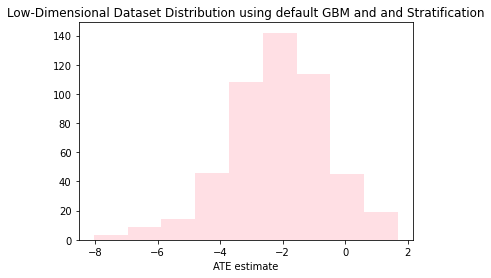

In [57]:
num_bins = 9
n, bins, patches = plt.hist(ATEs, num_bins, facecolor='pink', alpha=0.5)
plt.title(dataset_name + " Distribution using default GBM and and Stratification")
plt.xlabel("ATE estimate")
plt.show()

Thus, for high dimensional dataset, the result can be trusted with uncertainty at around $5 \%$, while for low dimensional dataset only give order of magnitude estimate. This may be due the to high dimensional dataset being larger. 

## Result summary

In [38]:
summary_cols=["Model", "Data", "PS model", "Estimation time(s)","Squared error"]
summary = pd.DataFrame(columns=summary_cols)

In [39]:
def estimation_summary(dataset:pd.DataFrame, max_k:int, true_ATE=true_ATE, title="high", resample=None, boost='GBM'):
    """
    data:pd.DataFrame, data_X:pd.DataFrame,
    This function reads in data and returns best ATE estimation generated from the 
    most appropriate k value for each algorithm.
    
    inputs
    -------
    data: pd.DataFrame, columns are (e, Y, A)
    data_X: pd.DataFrame, the set of X variables
    max_k: int, the maximum k value used to calculate ATE
    true_ATE: float, the true ATE score used to plot against estimations
    title: str, a string used to label high/low-dimensional datasets in the plot. Possible values are "high" or "low"
    
    outputs
    -------
    strat: float, best ATE estimate by stratification
    regadj: float, best ATE estimate by regression adjustment
    combined: float, best ATE estimate by stratification + regression adjustment
    log: pd.DataFrame, chunk of summary table
    
    """
    data, data_X = data_preparation_pipeline(dataset, resample=resample, label=dataset_name, boost=boost)
    
    strat_results = [Calculate_ATE_Strat(data, i) for i in range(1, max_k+1)]
    strat_reg_results = [Calculate_ATE_StratRegrAdjusted_with_X(data, data_X, i) for i in range(1, max_k+1)]
    
    error = [abs(strat_results[i] - true_ATE) for i in range(len(strat_results))]
    best_k_strat = error.index(min(error))+1
    #best_ATE_strat = strat_results[best_k_strat]
    
    error = [abs(strat_reg_results[i] - true_ATE) for i in range(len(strat_reg_results))]
    best_k_strat_reg = error.index(min(error))+1
    #best_ATE_strat_reg = strat_reg_results[best_k_strat_reg]
    
    start = time.time()
    strat = Calculate_ATE_Strat(data, best_k_strat)
    t_strat = time.time()-start
    print("Time for calculating ATE with stratification: {}s".format(round(t_strat, 4)))
    
    start = time.time()
    regadj = Calculate_ATE_StratRegrAdjusted_with_X(data, data_X, 1)
    t_regadj = time.time()-start
    print("Time for calculating ATE with regression adjustment: {}s".format(round(t_regadj, 4)))
    
    start = time.time()
    combined = Calculate_ATE_StratRegrAdjusted_with_X(data, data_X, best_k_strat_reg)
    t_combined = time.time()-start
    print("Time for calculating ATE with stratification + regression adjustment: {}s".format(round(t_combined, 4)))
    
    print("Estimated ATE by stratification with k = {}: {}".format(best_k_strat, strat))
    print("Estimated ATE by regression adjustment: {}".format(regadj))
    print("Estimated ATE by stratification + regression adjustment with k = {}: {}".format(best_k_strat_reg, combined))
    
    # resamping label
    if resample == 'over':
        resample_str = '(oversampled)'
    elif resample == 'smote':
        resample_str = '(SMOTE)'
    else: resample_str = ''
    
    # Add results to summary
    log = pd.DataFrame(columns=summary_cols)

    row1= pd.DataFrame([[str('Stratification (K={})'.format(best_k_strat+1)), str(title+'-dim'+resample_str), boost, 
                         t_strat, round((strat-true_ATE)**2,4)]], columns = summary_cols)
    log = log.append(row1)
    row2= pd.DataFrame([['Regression Adjustment', str(title+'-dim'+resample_str), boost, 
                         t_regadj, round((regadj - true_ATE)**2,4)]], columns = summary_cols)
    log = log.append(row2)
    row3= pd.DataFrame([[str('Strat. + Reg. Adj. (K={})'.format(best_k_strat_reg+1)), str(title+'-dim'+resample_str), boost, 
                         t_combined, round((combined - true_ATE)**2,4)]], columns = summary_cols)
    log = log.append(row3)
    
    
    # Plot: 
    plt.figure(figsize=(10,6))
    plt.plot(range(1,max_k+1), strat_results, marker='o',
                label = 'ATE estimate by stratification')
    plt.plot(range(1,max_k+1), strat_reg_results, marker='o',
                label = 'ATE estimate by strat + reg_adj')
    plt.scatter(1, regadj, s=150, label='ATE estimate by regression adjustment',alpha=1, marker='o',c='green')

    plt.hlines(true_ATE, 1, max_k, colors='red', linestyles='dashed', label='ATE true')
    #plt.hlines(naive_ATE(data), 1, 10, colors='grey', linestyles='dashed', label='ATE Naive')
    plt.title("The {}-dimensional dataset {}\nTrue vs. Estimated ATE (PS predicted by {})".format(title, resample_str,boost))
    plt.xlabel("Number of strata (k)")
    plt.ylabel("ATE")
    plt.legend()
    plt.show()
    
    return log

### High dimensional dataset

In [40]:
dataset = highDim_dataset.copy()
dataset_name = "High-Dimensional Dataset"
true_ATE = high_true_ATE

GBM parameters: {'learning_rate': 0.05, 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
GBM train accuracy:  0.740625
GBM test accuracy:  0.73
Time for calculating ATE with stratification: 0.0219s
Time for calculating ATE with regression adjustment: 0.0457s
Time for calculating ATE with stratification + regression adjustment: 0.0527s
Estimated ATE by stratification with k = 6: -54.804469699485615
Estimated ATE by regression adjustment: -59.36544369185163
Estimated ATE by stratification + regression adjustment with k = 2: -54.357121183238505


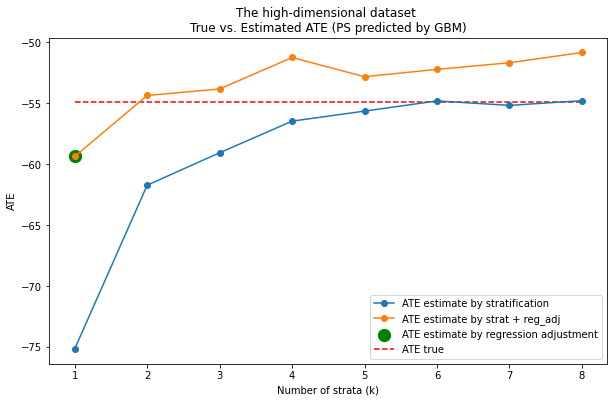

XGboost train accuracy:  0.83375
XGboost test accuracy:  0.695
Time for calculating ATE with stratification: 0.0094s
Time for calculating ATE with regression adjustment: 0.0384s
Time for calculating ATE with stratification + regression adjustment: 0.0479s
Estimated ATE by stratification with k = 3: -52.50678115580061
Estimated ATE by regression adjustment: -59.36544369185163
Estimated ATE by stratification + regression adjustment with k = 2: -54.99563005619707


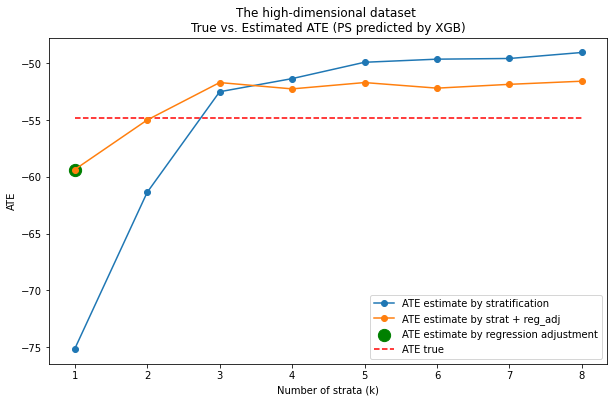

GBM parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}
GBM train accuracy:  0.9539382772915707
GBM test accuracy:  0.8011049723756906
Time for calculating ATE with stratification: 0.0074s
Time for calculating ATE with regression adjustment: 0.0465s
Time for calculating ATE with stratification + regression adjustment: 0.0628s
Estimated ATE by stratification with k = 2: -55.674646001460665
Estimated ATE by regression adjustment: -58.56244111764775
Estimated ATE by stratification + regression adjustment with k = 2: -54.87407062101991


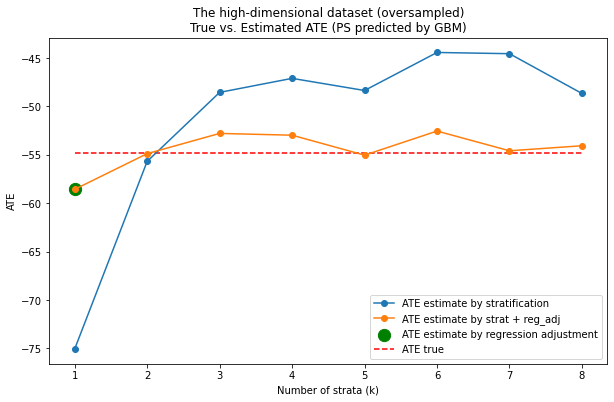

XGboost train accuracy:  0.8549055734684478
XGboost test accuracy:  0.7311233885819521
Time for calculating ATE with stratification: 0.0141s
Time for calculating ATE with regression adjustment: 0.0786s
Time for calculating ATE with stratification + regression adjustment: 0.1423s
Estimated ATE by stratification with k = 2: -55.46699829573244
Estimated ATE by regression adjustment: -58.28547401236521
Estimated ATE by stratification + regression adjustment with k = 7: -54.611877160416704


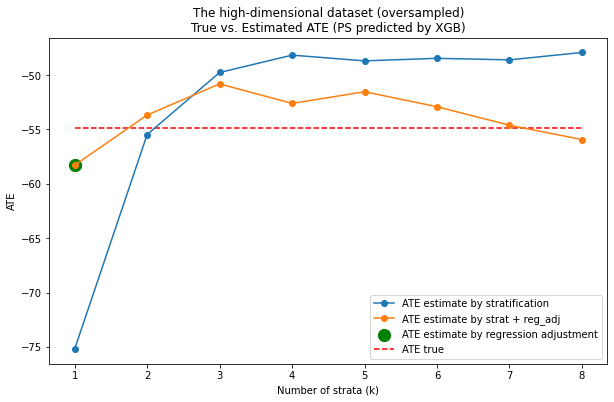

GBM parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}
GBM train accuracy:  0.9706578324656886
GBM test accuracy:  0.7939508506616257
Time for calculating ATE with stratification: 0.0093s
Time for calculating ATE with regression adjustment: 0.0459s
Time for calculating ATE with stratification + regression adjustment: 0.1067s
Estimated ATE by stratification with k = 3: -54.76266966276221
Estimated ATE by regression adjustment: -58.46123323702967
Estimated ATE by stratification + regression adjustment with k = 7: -56.31700008722542


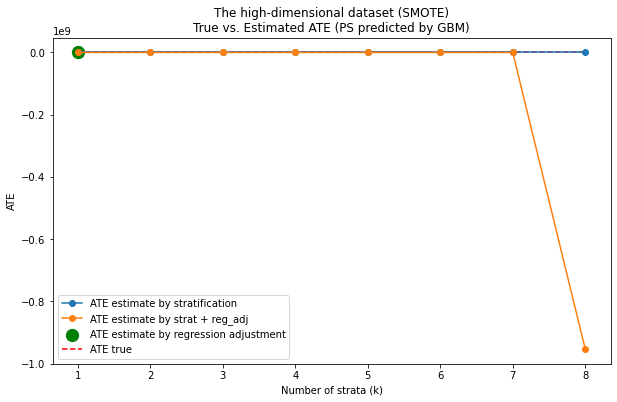

XGboost train accuracy:  0.8847969782813976
XGboost test accuracy:  0.7830188679245284
Time for calculating ATE with stratification: 0.0075s
Time for calculating ATE with regression adjustment: 0.0494s
Time for calculating ATE with stratification + regression adjustment: 0.1539s
Estimated ATE by stratification with k = 2: -55.828390830098385
Estimated ATE by regression adjustment: -57.640711097655206
Estimated ATE by stratification + regression adjustment with k = 3: -54.762397622603885


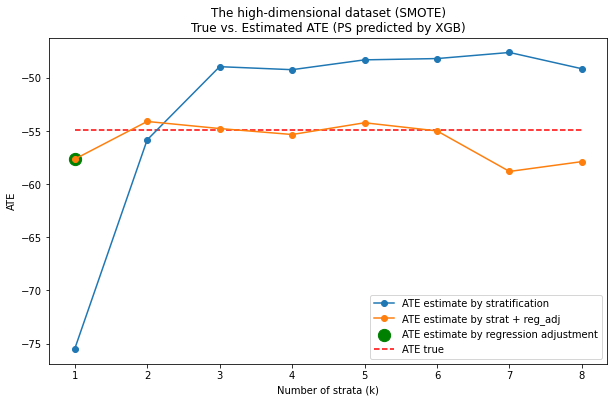

In [41]:
for r in [None,'over','smote']:
    for b in ['GBM','XGB']:
        log = estimation_summary(dataset, max_k=8, true_ATE=true_ATE, title="high", resample=r, boost=b)
        summary = summary.append(log)

**Note: The ATE estimates become more inaccurate for larger numbers of strata (K>8), so here we only plot reasonable K values.**

### Low dimensional dataset

In [42]:
dataset = lowDim_dataset.copy()
dataset_name = "Low-Dimensional Dataset"
true_ATE = low_true_ATE

GBM parameters: {'learning_rate': 0.05, 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
GBM train accuracy:  0.88
GBM test accuracy:  0.81
Time for calculating ATE with stratification: 0.0092s
Time for calculating ATE with regression adjustment: 0.0059s
Time for calculating ATE with stratification + regression adjustment: 0.0266s
Estimated ATE by stratification with k = 3: 1.6442907345555777
Estimated ATE by regression adjustment: 2.472655707042314
Estimated ATE by stratification + regression adjustment with k = 8: 2.098806025381446


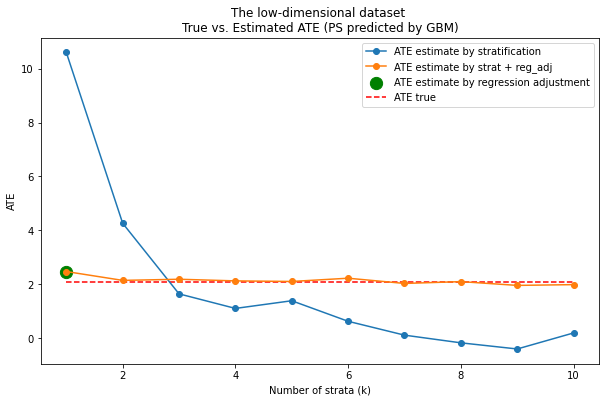

XGboost train accuracy:  0.8975
XGboost test accuracy:  0.77
Time for calculating ATE with stratification: 0.0101s
Time for calculating ATE with regression adjustment: 0.0097s
Time for calculating ATE with stratification + regression adjustment: 0.0106s
Estimated ATE by stratification with k = 3: 2.5211826326484754
Estimated ATE by regression adjustment: 2.472655707042314
Estimated ATE by stratification + regression adjustment with k = 2: 2.0909508275719024


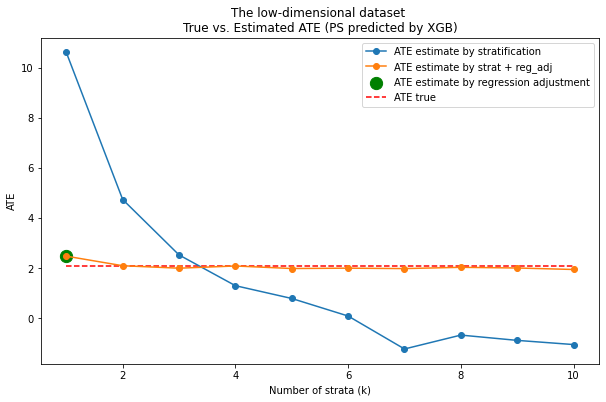

GBM parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}
GBM train accuracy:  0.9682539682539683
GBM test accuracy:  0.879746835443038
Time for calculating ATE with stratification: 0.0246s
Time for calculating ATE with regression adjustment: 0.0086s
Time for calculating ATE with stratification + regression adjustment: 0.0327s
Estimated ATE by stratification with k = 5: 2.0038190425405134
Estimated ATE by regression adjustment: 2.2311911804917886
Estimated ATE by stratification + regression adjustment with k = 1: 2.2311911804917886


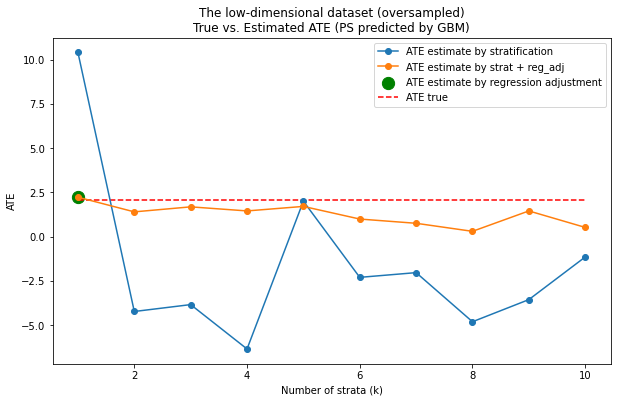

XGboost train accuracy:  0.9063492063492063
XGboost test accuracy:  0.8291139240506329
Time for calculating ATE with stratification: 0.0227s
Time for calculating ATE with regression adjustment: 0.0074s
Time for calculating ATE with stratification + regression adjustment: 0.0361s
Estimated ATE by stratification with k = 5: 1.8217462735501744
Estimated ATE by regression adjustment: 2.2057427005527437
Estimated ATE by stratification + regression adjustment with k = 10: 2.161594698952099


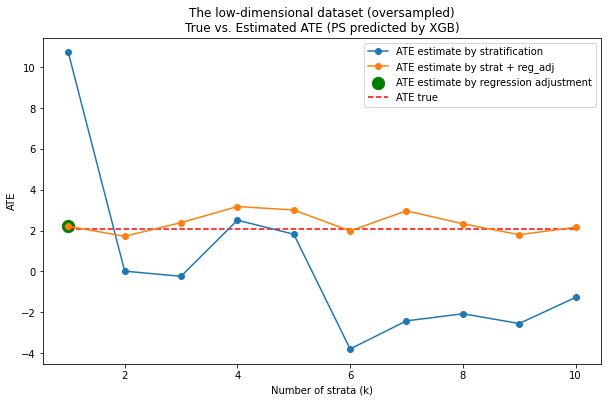

GBM parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}
GBM train accuracy:  0.9836601307189542
GBM test accuracy:  0.7727272727272727
Time for calculating ATE with stratification: 0.0064s
Time for calculating ATE with regression adjustment: 0.0058s
Time for calculating ATE with stratification + regression adjustment: 0.0153s
Estimated ATE by stratification with k = 2: 2.2199679611717533
Estimated ATE by regression adjustment: 2.426751627221818
Estimated ATE by stratification + regression adjustment with k = 4: 2.1856679563378245


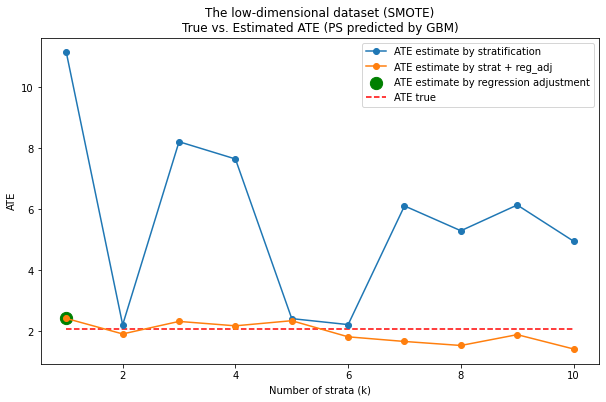

XGboost train accuracy:  0.8876221498371335
XGboost test accuracy:  0.7467532467532467
Time for calculating ATE with stratification: 0.0073s
Time for calculating ATE with regression adjustment: 0.0068s
Time for calculating ATE with stratification + regression adjustment: 0.0143s
Estimated ATE by stratification with k = 2: 1.3820251494950293
Estimated ATE by regression adjustment: 2.4249145226712514
Estimated ATE by stratification + regression adjustment with k = 3: 2.199451337966208


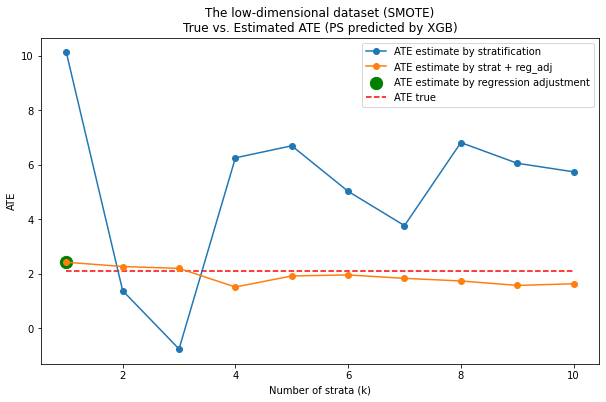

In [43]:
for r in [None,'over','smote']:
    for b in ['GBM','XGB']:
        log = estimation_summary(dataset, max_k=10, true_ATE=true_ATE, title="low", resample=r, boost=b)
        summary = summary.append(log)

In [44]:
summary.sort_values(by=['Squared error', 'Estimation time(s)'])

,Model,Data,PS model,Estimation time(s),Squared error
0,Strat. + Reg. Adj. (K=3),low-dim,XGB,0.010584,0.0000
0,Strat. + Reg. Adj. (K=9),low-dim,GBM,0.026632,0.0001
0,Strat. + Reg. Adj. (K=3),high-dim(oversampled),GBM,0.062807,0.0003
0,Stratification (K=7),high-dim,GBM,0.021905,0.0026
0,Strat. + Reg. Adj. (K=11),low-dim(oversampled),XGB,0.036070,0.0051
0,Stratification (K=6),low-dim(oversampled),GBM,0.024617,0.0074
0,Stratification (K=4),high-dim(SMOTE),GBM,0.009333,0.0087
0,Strat. + Reg. Adj. (K=4),high-dim(SMOTE),XGB,0.153934,0.0087
0,Strat. + Reg. Adj. (K=5),low-dim(SMOTE),GBM,0.015306,0.0091
0,Strat. + Reg. Adj. (K=4),low-dim(SMOTE),XGB,0.014308,0.0120


In [48]:
summary = summary.reset_index().drop(['index'], axis=1)
summary.to_csv('../output/summary.csv', index=False)

## Conclusion and recommendations

Among three algorithms, **regression** is the simplest, while **stratification with regression adjustment** is the most complicated model. The regression precedure makes use of the covariate variable $X$ to account for the confounding factor, while the **stratification** makes use of the assumption that the treatment exposure is unrelated to the counterfactuals for individual sharing the propensity score (X and T independent within strata). Theoretically, the **stratification with regression adjustment**, which was shown to offer an unbiased estimate, offers a **double robustness** even when the regression models are incorrect, thus should be the most accurate.  

On the estimation accuracy, for the low-dimensional dataset, **stratification with regression adjustment** has the most accurate estimate. On the high-dimensional dataset, **stratification** achieves the best ATE estimate closest to the true ATE by setting $k = 5$. Interestingly, the **regression** gives a smaller estimate, while **regression adjustment to stratification** gives higher estimate. This reduction of accuracy may be due to esimation for the propensity score being overfitted. A shallower tree stump model (with only 10 estimator) indicates the reverse: **stratification adjustment** actually offers an improvement over **stratification** and gives the best result. 

The number of strata $k$ was optimized at 5 bins, as higher number of bins creates imbalance between strata. For some higher number of $k$, it was observed that some bins contain no $T = 1$ datapoint.

On time complexity, **stratification with regression adjustment** is generally the lowest when estimating ATE. **Regression adjustment** works the fastest when the dataset has low dimensions, but when the dataset increases in its dimensionality, **Regression adjustment** slows down and **stratification** becomes faster.

We also discussed the effects of resampling on the model performance. Since the dataset was not too imbalance and GBM model is quite robust, there was little improvement. 

In summary, both **stratification** and **stratification with regression adjustment** are flexible which enable us to choose a specified k that fits the dataset better, whereas **regression adjustment** procedure is mostly set and offers less adjustibility. To check the **stratification**, it is recommended that one makes sure the bins are balanced between the treatment/control group. Finally, the propensity score should not be overfitted, as this will skew the confound factor extracted from the covariate variable $X$. 

In [49]:
summary = pd.read_csv('../output/summary.csv')
# Sort by estimation accuracy
summary.sort_values(by=['Squared error', 'Estimation time(s)'])

,Model,Data,PS model,Estimation time(s),Squared error
23,Strat. + Reg. Adj. (K=3),low-dim,XGB,0.010584,0.0000
20,Strat. + Reg. Adj. (K=9),low-dim,GBM,0.026632,0.0001
8,Strat. + Reg. Adj. (K=3),high-dim(oversampled),GBM,0.062807,0.0003
0,Stratification (K=7),high-dim,GBM,0.021905,0.0026
29,Strat. + Reg. Adj. (K=11),low-dim(oversampled),XGB,0.036070,0.0051
24,Stratification (K=6),low-dim(oversampled),GBM,0.024617,0.0074
12,Stratification (K=4),high-dim(SMOTE),GBM,0.009333,0.0087
17,Strat. + Reg. Adj. (K=4),high-dim(SMOTE),XGB,0.153934,0.0087
32,Strat. + Reg. Adj. (K=5),low-dim(SMOTE),GBM,0.015306,0.0091
35,Strat. + Reg. Adj. (K=4),low-dim(SMOTE),XGB,0.014308,0.0120


In [50]:
# Sort by time complexity
summary.sort_values(by=['Estimation time(s)'])

,Model,Data,PS model,Estimation time(s),Squared error
31,Regression Adjustment,low-dim(SMOTE),GBM,0.005775,0.1133
19,Regression Adjustment,low-dim,GBM,0.005897,0.1463
30,Stratification (K=3),low-dim(SMOTE),GBM,0.006426,0.0169
34,Regression Adjustment,low-dim(SMOTE),XGB,0.006801,0.1121
33,Stratification (K=3),low-dim(SMOTE),XGB,0.007330,0.5014
28,Regression Adjustment,low-dim(oversampled),XGB,0.007439,0.0134
6,Stratification (K=3),high-dim(oversampled),GBM,0.007442,0.6705
15,Stratification (K=3),high-dim(SMOTE),XGB,0.007509,0.9459
25,Regression Adjustment,low-dim(oversampled),GBM,0.008648,0.0199
18,Stratification (K=4),low-dim,GBM,0.009219,0.1987


## References


1. Chan, D., Ge, R., Gershony, O., Hesterberg, T. and Lambert, D., 2010, July. Evaluating online ad campaigns in a pipeline: causal models at scale. In Proceedings of the 16th ACM SIGKDD international conference on Knowledge discovery and data mining (pp. 7-16). https://doi.org/10.1145/1835804.1835809

2. D'Agostino Jr, R.B., 1998. Propensity score methods for bias reduction in the comparison of a treatment to a non‐randomized control group. Statistics in medicine, 17(19), pp.2265-2281. https://doi.org/10.1002/(SICI)1097-0258(19981015)17:19%3C2265::AID-SIM918%3E3.0.CO;2-B

3. Hirano, K. and Imbens, G.W., 2001. Estimation of causal effects using propensity score weighting: An application to data on right heart catheterization. Health Services and Outcomes research methodology, 2(3), pp.259-278. https://doi.org/10.1023/A:1020371312283

4. Austin, P.C., 2011. An introduction to propensity score methods for reducing the effects of confounding in observational studies. Multivariate behavioral research, 46(3), pp.399-424. https://dx.doi.org/10.1080%2F00273171.2011.568786

5. Stuart, E.A., 2009. Matching methods for causal inference: A review and a look forward. Baltimore, MD: Johns Hopkins Bloomberg School of Public Health. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2943670/

6. Lunceford, J.K., 2017. Stratification and weighting via the propensity score in estimation of causal treatment effects: a comparative study. Statistics in medicine, 36(14), pp.2320-2320. https://doi.org/10.1002/sim.1903

7. Overcoming Class Imbalance using SMOTE Techniques, https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/#:~:text=SMOTE%20is%20an%20oversampling%20technique%20where%20the%20synthetic,interpolation%20between%20the%20positive%20instances%20that%20lie%20together.

8. Github Page of Applied Data Science https://github.com/TZstatsADS/ADS_Teaching/blob/master/Projects_StarterCodes/Project4-CausalInference/doc/project4_desc.md
